---
title: "Exploratory Data Analysis"
format:
    html: 
        code-fold: true
---

<!-- After digesting the instructions, you can delete this cell, these are assignment instructions and do not need to be included in your final submission.  -->

{{< include instructions.qmd >}} 

# Code 

Provide the source code used for this section of the project here.

If you're using a package for code organization, you can import it at this point. However, make sure that the **actual workflow steps**—including data processing, analysis, and other key tasks—are conducted and clearly demonstrated on this page. The goal is to show the technical flow of your project, highlighting how the code is executed to achieve your results.

If relevant, link to additional documentation or external references that explain any complex components. This section should give readers a clear view of how the project is implemented from a technical perspective.

Remember, this page is a technical narrative, NOT just a notebook with a collection of code cells, include in-line Prose, to describe what is going on.

### Word Cloud
- for each driver
- top 10 most frequent words in their respective news articles

In [30]:
# import required libraries
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import json
import os

In [31]:
# Function to generate a word cloud for a single JSON file
def generate_wordcloud_top_n(file_path, output_folder, top_n=10):
    def plot_cloud(wordcloud, output_file):
        plt.figure(figsize=(10, 8))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.savefig(output_file)  # Save the plot
        plt.show()  # Display the plot
        plt.close()

    # Read the text from the JSON file
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)

    # Concatenate all text content if it's a JSON dictionary
    if isinstance(data, dict):
        my_text = ' '.join(data.values())

    # Generate word cloud to extract word frequencies
    wordcloud = WordCloud(
        width=3000,
        height=2000,
        random_state=1,
        colormap="PuBuGn",
        collocations=False,
        stopwords=STOPWORDS
    ).generate(my_text)

    # Extract word frequencies and get the top N words
    word_frequencies = wordcloud.words_
    top_words = dict(list(word_frequencies.items())[:top_n])

    # Generate a new word cloud with only the top N words
    top_wordcloud = WordCloud(
        width=3000,
        height=2000,
        random_state=1,
        colormap="PuBuGn",
        collocations=False,
        stopwords=STOPWORDS
    ).generate_from_frequencies(top_words)

    # Save and display the word cloud
    file_name = os.path.basename(file_path).replace('.json', '_wordcloud.png')
    output_file = os.path.join(output_folder, file_name)
    plot_cloud(top_wordcloud, output_file)
    print(f"Word cloud saved to: {output_file}")


# Function to process all JSON files in a folder
def generate_wordclouds_for_folder(input_folder, output_folder, top_n=10):
    os.makedirs(output_folder, exist_ok=True)  # Ensure the output folder exists

    for file_name in os.listdir(input_folder):
        if file_name.endswith('.json'):  # Process only JSON files
            file_path = os.path.join(input_folder, file_name)
            try:
                generate_wordcloud_top_n(file_path, output_folder, top_n)
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")


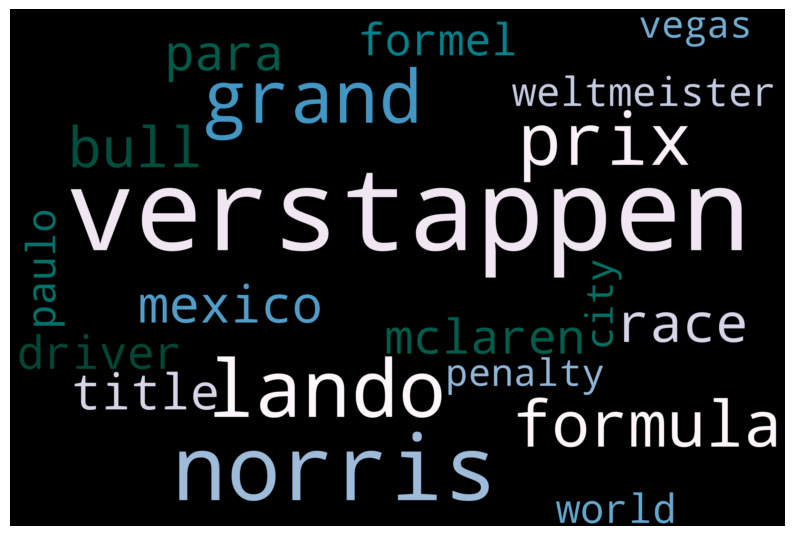

Word cloud saved to: ../../data/eda/WordClouds/Verstappen_clean_news_wordcloud.png


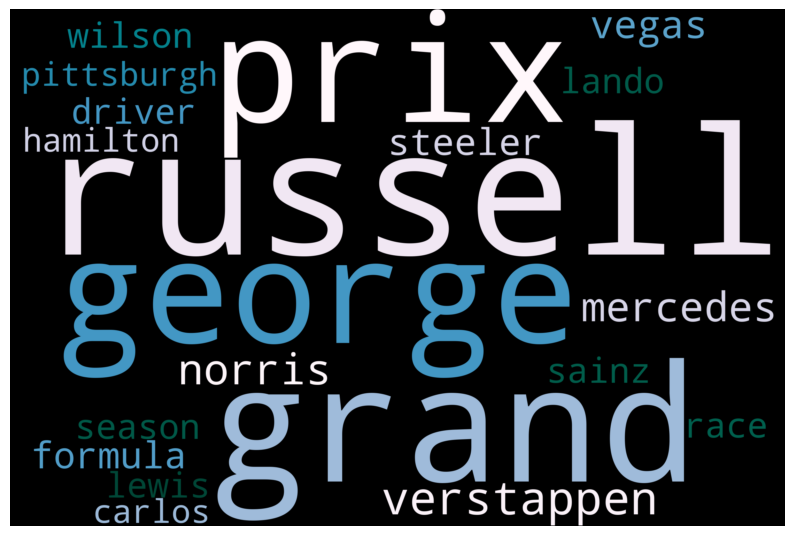

Word cloud saved to: ../../data/eda/WordClouds/Russell_clean_news_wordcloud.png


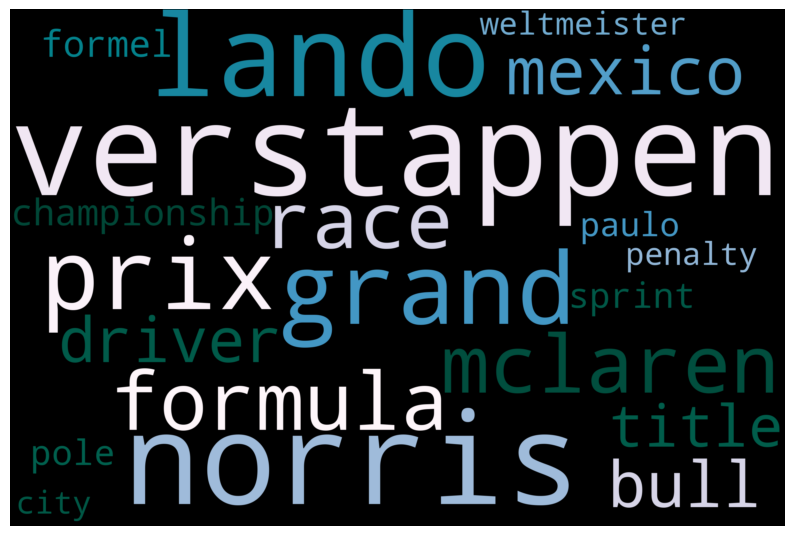

Word cloud saved to: ../../data/eda/WordClouds/Norris_clean_news_wordcloud.png


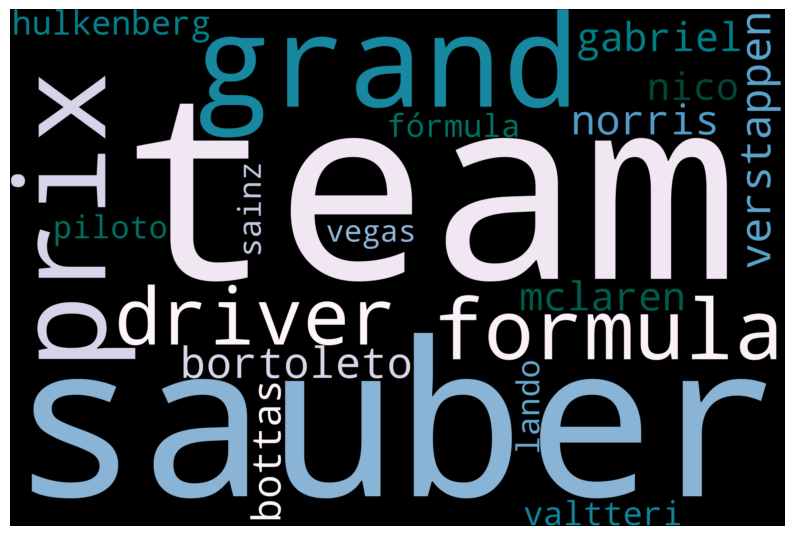

Word cloud saved to: ../../data/eda/WordClouds/Hulkenberg_clean_news_wordcloud.png


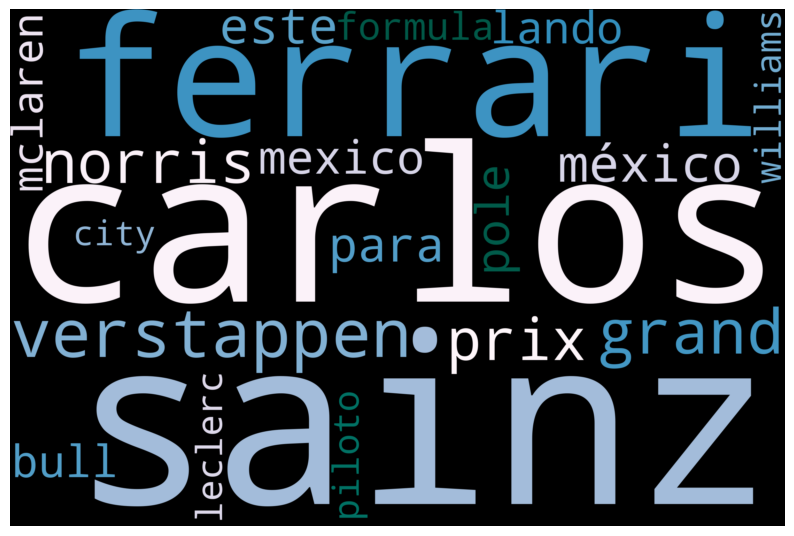

Word cloud saved to: ../../data/eda/WordClouds/Sainz_clean_news_wordcloud.png


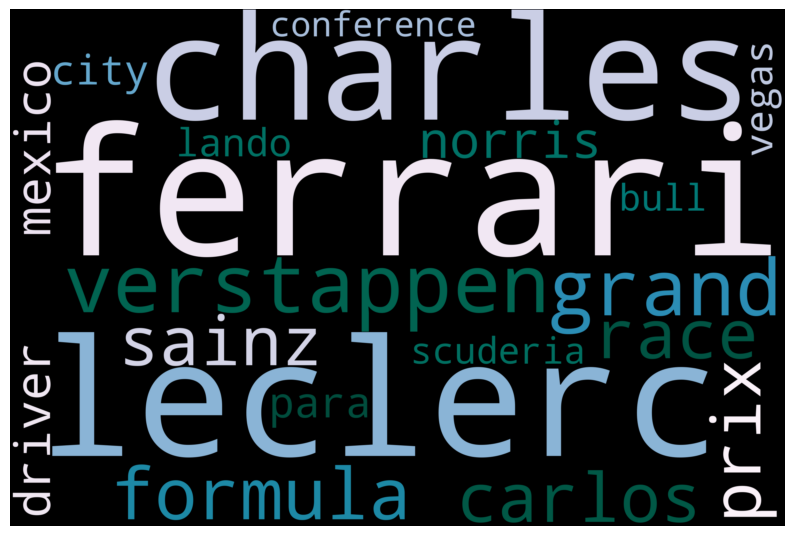

Word cloud saved to: ../../data/eda/WordClouds/Leclerc_clean_news_wordcloud.png


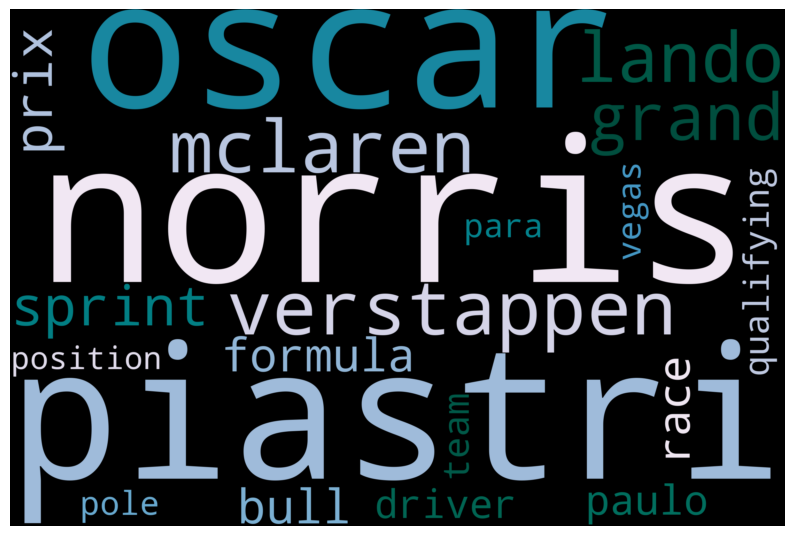

Word cloud saved to: ../../data/eda/WordClouds/Piastri_clean_news_wordcloud.png


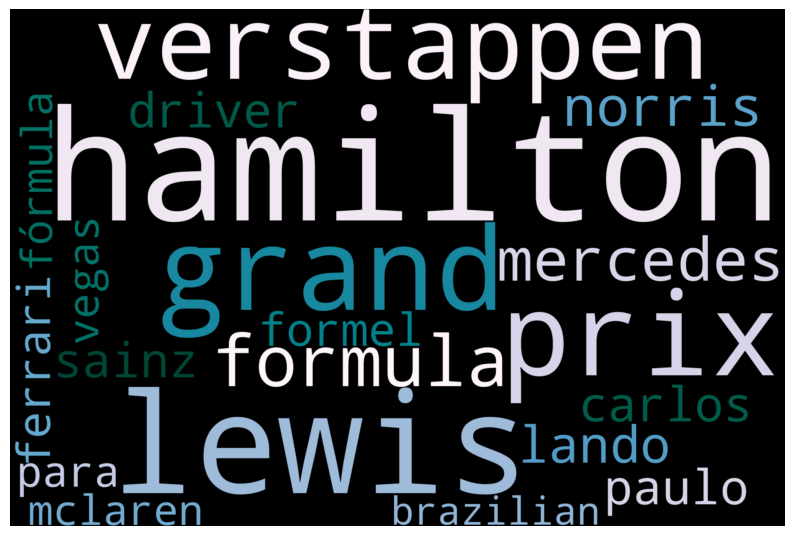

Word cloud saved to: ../../data/eda/WordClouds/Hamilton_clean_news_wordcloud.png


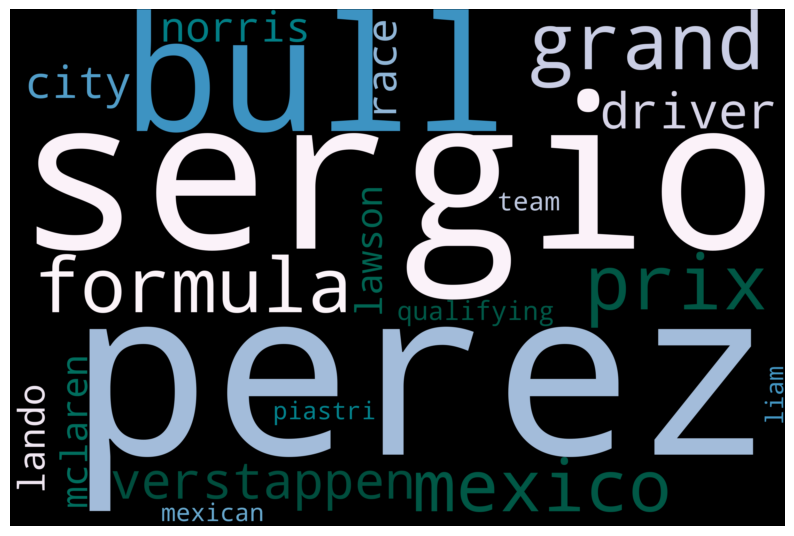

Word cloud saved to: ../../data/eda/WordClouds/Perez_clean_news_wordcloud.png


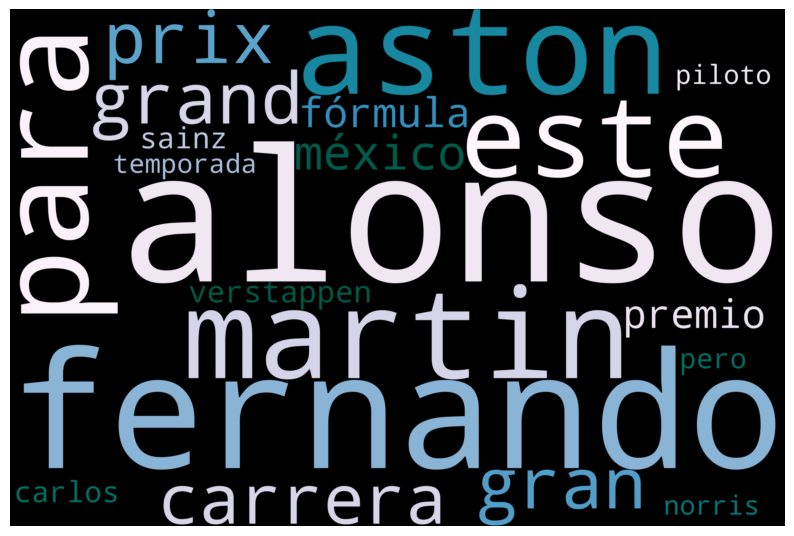

Word cloud saved to: ../../data/eda/WordClouds/Alonso_clean_news_wordcloud.png


In [32]:
# Example usage
input_folder = "../../data/processed-data/News_Drivers/" 
output_folder = "../../data/eda/WordClouds/"  
generate_wordclouds_for_folder(input_folder, output_folder, top_n=20)